<h2>Data Description</h2>

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.



In [2]:
# pip install lightgbm

Note: you may need to restart the kernel to use updated packages.Successfully installed lightgbm-3.3.0



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import datetime 

In [4]:
pd.set_option('display.max_colwidth',None)

<h2>File descriptions</h2>
<ul>
<li>sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.</li> 
<li> test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.</li> 
<li> sample_submission.csv - a sample submission file in the correct format.</li> 
<li> items.csv - supplemental information about the items/products.</li> 
<li> item_categories.csv  - supplemental information about the items categories.</li> 
<li> shops.csv- supplemental information about the shops.</li> 
</ul>

In [37]:
items = pd.read_csv('./data/items.csv')
item_cat = pd.read_csv('./data/item_categories.csv')
shops = pd.read_csv('./data/shops.csv')

sales = pd.read_csv('./data/sales_train.csv')
test = pd.read_csv('./data/test.csv')

In [38]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [39]:
sales.shape

(2935849, 6)

In [13]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## EDA

<h2>Data fields</h2>
<ul>
<li>ID - an Id that represents a (Shop, Item) tuple within the test set</li>
<li>shop_id - unique identifier of a shop
<li>item_id - unique identifier of a product
<li>item_category_id - unique identifier of item category
<li>item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
<li>item_price - current price of an item
<li>date - date in format dd/mm/yyyy
<li>date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
<li>item_name - name of item
<li>shop_name - name of shop
<li>item_category_name - name of item category
 </ul>

### Checking for correlation 

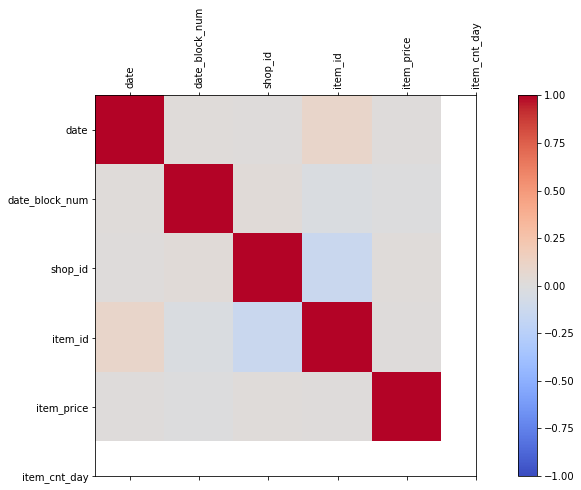

In [41]:
corr = sales.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(train_dataset.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_dataset.columns)
ax.set_yticklabels(train_dataset.columns)
plt.show()

### Checking how many items sold per category

In [42]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


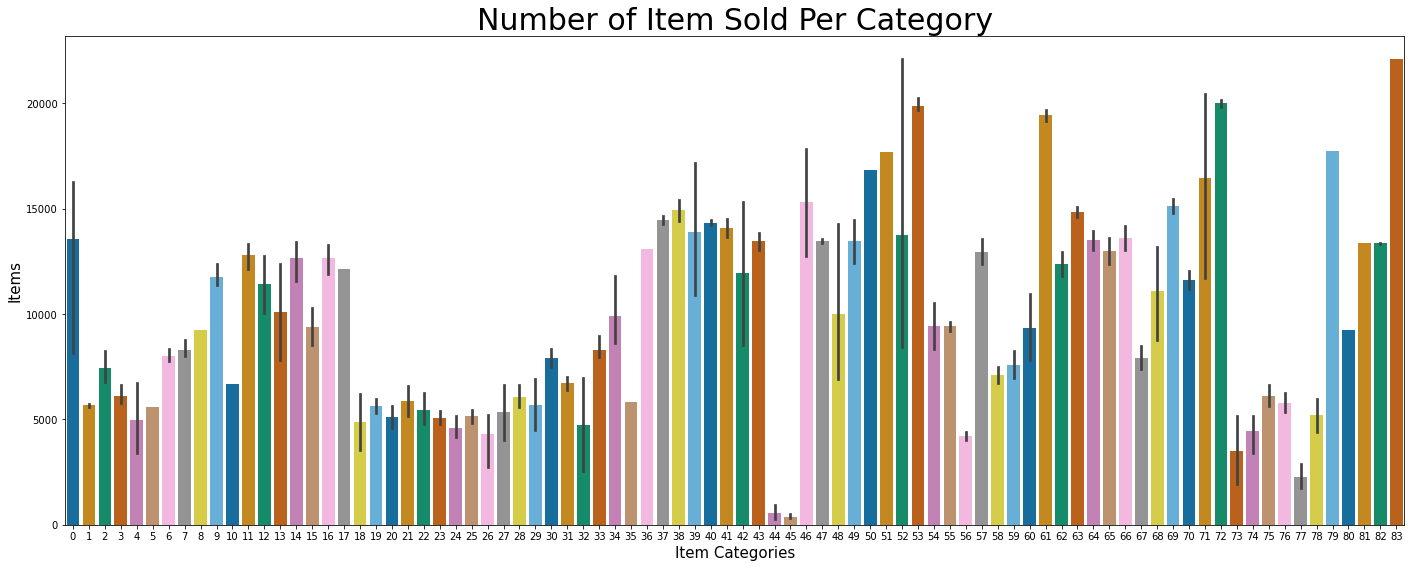

In [43]:
plt.rcParams['figure.figsize'] = (24, 9)
sns.barplot(items['item_category_id'], items['item_id'], palette = 'colorblind')
plt.title('Number of Item Sold Per Category', fontsize = 30)
plt.xlabel('Item Categories', fontsize = 15)
plt.ylabel('Items', fontsize = 15)
plt.show()


### Checking how many items sold per per month i.e. (jan 2013 ~ Oct 2015)

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


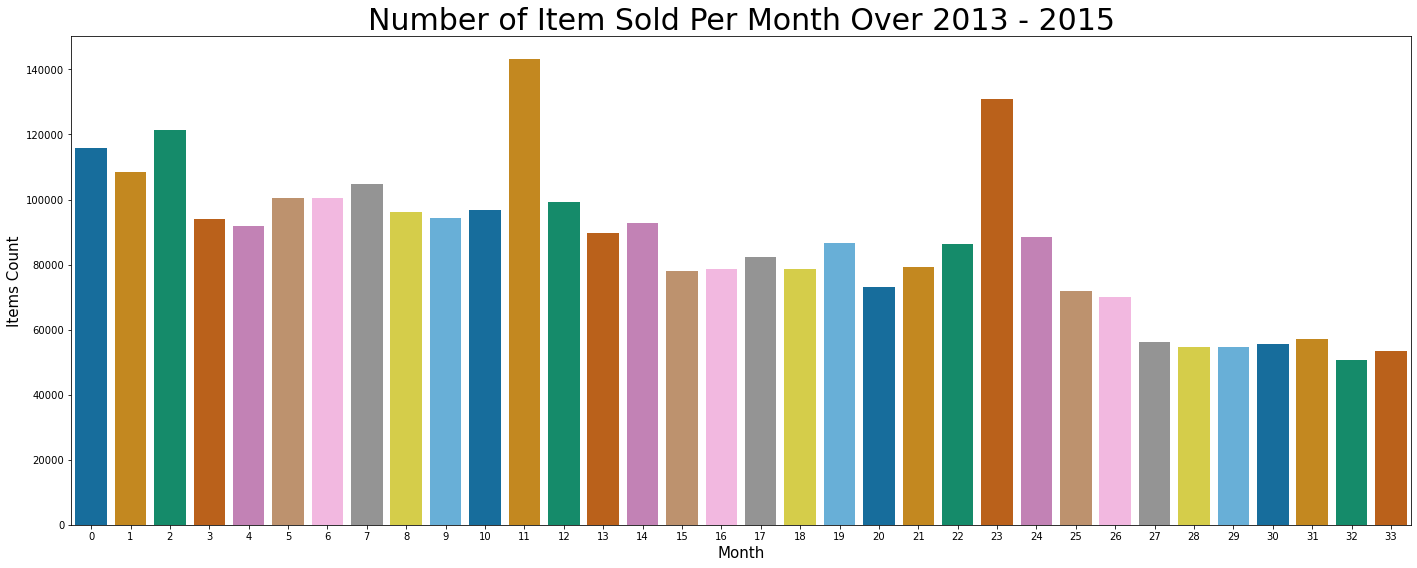

In [45]:
plt.rcParams['figure.figsize'] = (24, 9)
sns.countplot(sales['date_block_num'], palette = 'colorblind')
plt.title('Number of Item Sold Per Month Over 2013 - 2015', fontsize = 30)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Items Count', fontsize = 15)
plt.show()

### WordCloud for shop name

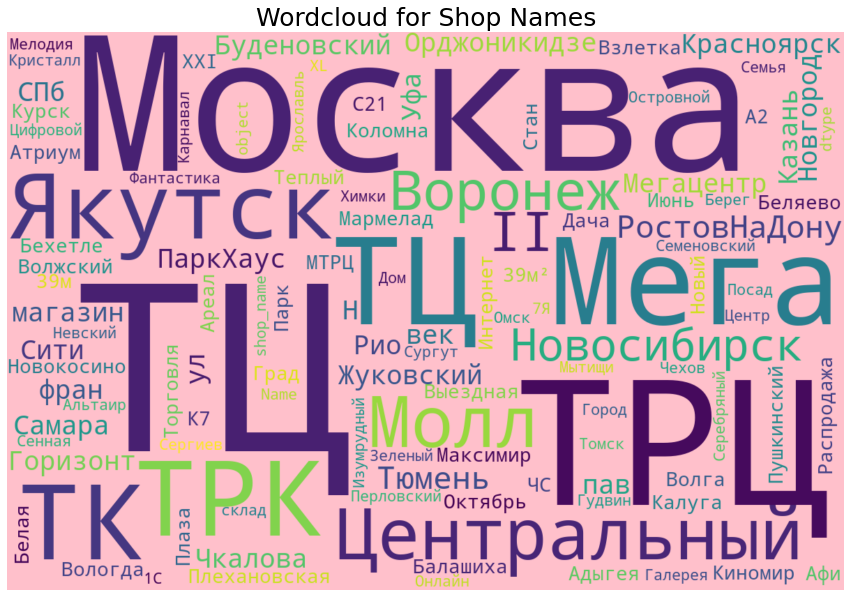

In [46]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'pink',
                      max_words = 200, 
                      stopwords = stopwords,
                     width = 1200,
                     height = 800,
                     random_state = 42).generate(str(shops['shop_name']))


plt.title('Wordcloud for Shop Names', fontsize = 25)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

### wordcloud for item categories



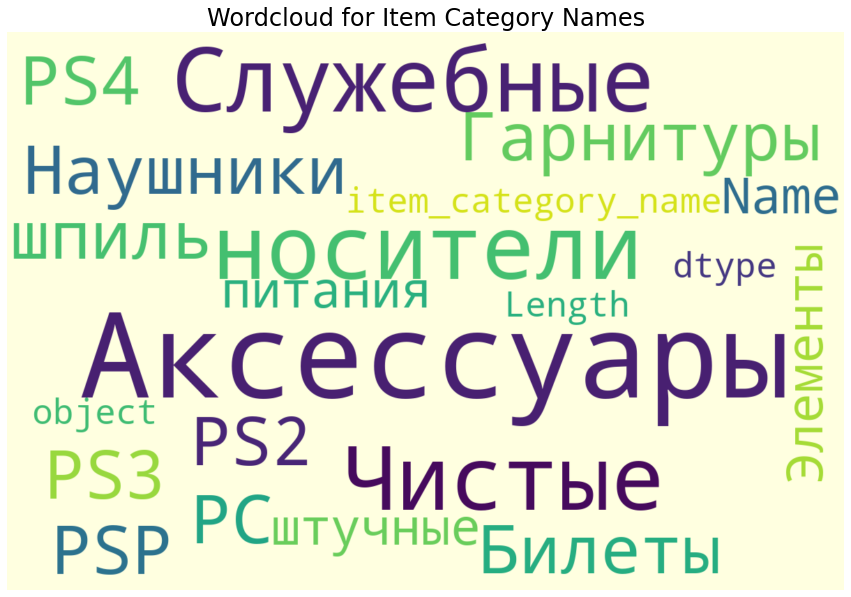

In [47]:
plt.rcParams['figure.figsize'] = (15, 12)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'lightyellow',
                      max_words = 200, 
                      stopwords = stopwords,
                     width = 1200,
                     height = 800,
                     random_state = 42).generate(str(item_cat['item_category_name']))


plt.title('Wordcloud for Item Category Names', fontsize = 24)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

### Busiest days for the shop

### converting the date into datetime format

In [49]:
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')

In [50]:
days = []
months = []
years = []

for day in sales['date']:
    days.append(day.day)
for month in sales['date']:
    months.append(month.month)    
for year in sales['date']:
    years.append(year.year)

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


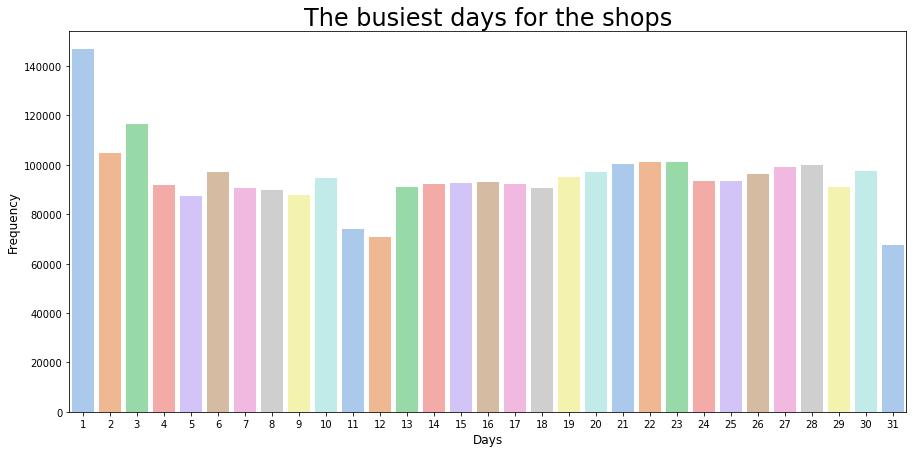

In [51]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(days, palette= 'pastel')
plt.title('The busiest days for the shops', fontsize = 24)
plt.xlabel('Days', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

### Busiest months and years for shops



D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


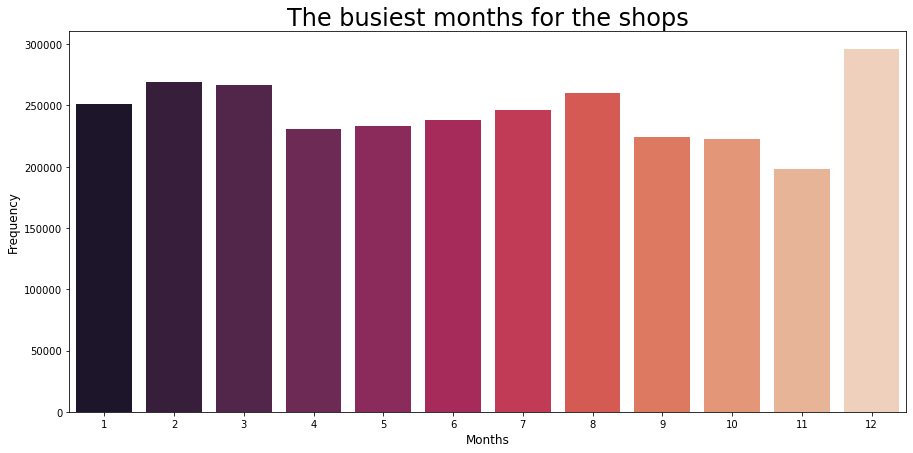

D:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


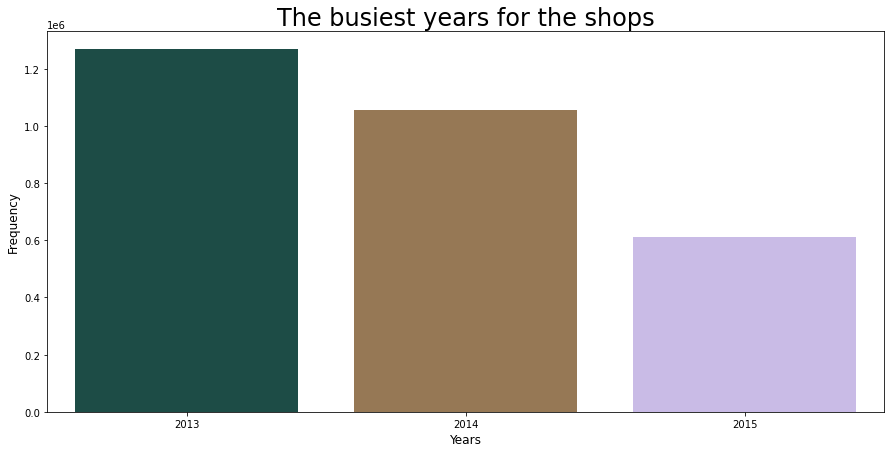

In [52]:
# busy month
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(months, palette= 'rocket')
plt.title('The busiest months for the shops', fontsize = 24)
plt.xlabel('Months', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

# busy year
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(years, palette= 'cubehelix')
plt.title('The busiest years for the shops', fontsize = 24)
plt.xlabel('Years', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

## Dataset merging operation


In [55]:
df_item=pd.merge(items,item_cat,on='item_category_id',how='inner')
sales_train=pd.merge(sales,shops,on='shop_id',how='inner')
sales=pd.merge(sales_train,df_item,on='item_id',how='inner')

## keeping only the data in train dataset, present in the test dataset.


In [56]:
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]
sales = sales[sales['item_id'].isin(test['item_id'].unique())]

In [57]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-02-01,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-02-01,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
2,2013-03-01,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
3,2013-01-20,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
4,2013-01-23,0,25,22154,999.0,1.0,"Москва ТРК ""Атриум""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
...,...,...,...,...,...,...,...,...,...,...
2935361,2015-10-29,33,55,12733,1490.0,1.0,Цифровой склад 1С-Онлайн,"КОМПАС-3D V16 Home эл. лиц. 1 год [PC, Цифровая версия]",76,Программы - Для дома и офиса (Цифра)
2935362,2015-10-28,33,55,12733,1490.0,1.0,Цифровой склад 1С-Онлайн,"КОМПАС-3D V16 Home эл. лиц. 1 год [PC, Цифровая версия]",76,Программы - Для дома и офиса (Цифра)
2935391,2015-10-28,33,55,1819,1499.0,3.0,Цифровой склад 1С-Онлайн,"Batman: Рыцарь Аркхема. Premium Edition [PC, Цифровая версия]",31,Игры PC - Цифра
2935392,2015-10-29,33,55,1819,1499.0,1.0,Цифровой склад 1С-Онлайн,"Batman: Рыцарь Аркхема. Premium Edition [PC, Цифровая версия]",31,Игры PC - Цифра


## Outliers

<AxesSubplot:xlabel='item_cnt_day'>

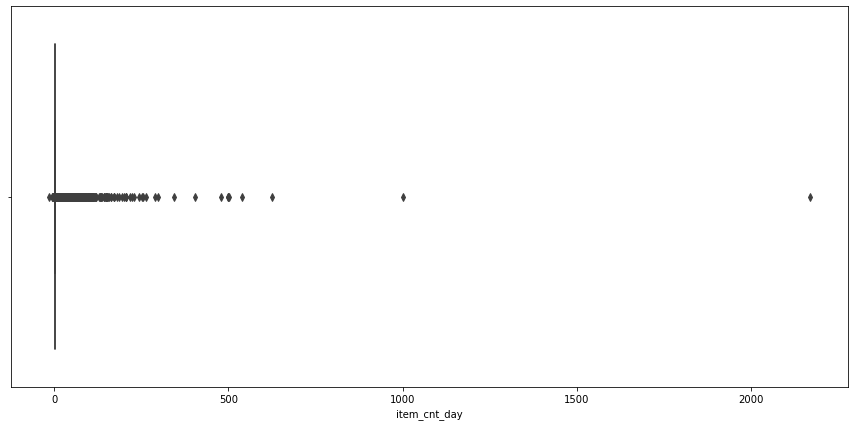

In [58]:
sns.boxplot(x=sales.item_cnt_day)

<AxesSubplot:xlabel='item_price'>

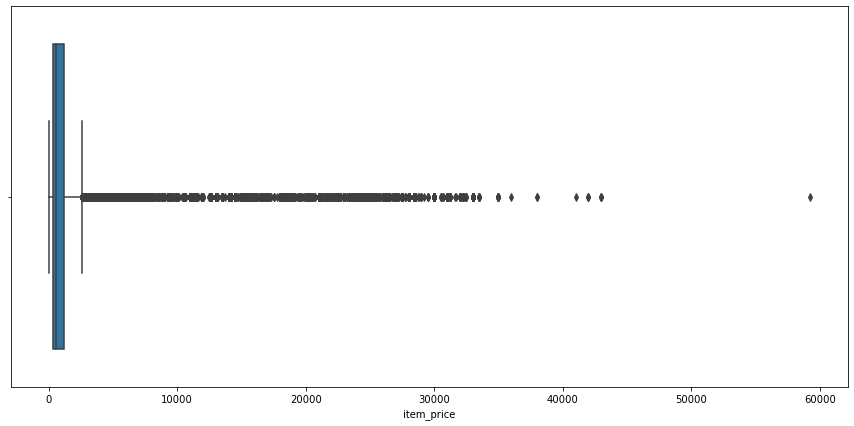

In [59]:
sns.boxplot(x=sales.item_price)

### Remove outliers

In [60]:
sales = sales[(sales.item_price < 350000 )& (sales.item_cnt_day < 1000)]
# remove negative item price
sales = sales[sales.item_price > 0].reset_index(drop = True)

### Aggregation on monthly basis


In [66]:
sales = sales.groupby(["date_block_num","shop_id","item_id"]).agg({"date_block_num":'mean',"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [67]:
sales

date_block_num       date             \
                                         mean        min        max   
date_block_num shop_id item_id                                        
0              2       33                   0 2013-05-01 2013-05-01   
                       482                  0 2013-01-16 2013-01-16   
                       491                  0 2013-09-01 2013-09-01   
                       839                  0 2013-01-22 2013-01-22   
                       1007                 0 2013-01-21 2013-11-01   
...                                       ...        ...        ...   
33             59      22087               33 2015-05-10 2015-10-23   
                       22088               33 2015-03-10 2015-10-27   
                       22091               33 2015-03-10 2015-03-10   
                       22100               33 2015-10-18 2015-10-18   
                       22102               33 2015-10-16 2015-10-16   

                               item_price item_cnt_day  
                                     mean          sum  
date_block_num shop_id item_id                          
0              2       33           499.0          1.0  
                       482         3300.0          1.0  
                       491          600.0          1.0  
                       839         3300.0          1.0  
                       1007         449.0          3.0  
...                                   ...          ...  
33             59      22087        119.0          6.0  
                       22088        119.0          2.0  
                       22091        179.0          1.0  
                       22100        629.0          1.0  
                       22102       1250.0          1.0  

[600158 rows x 5 columns]

In [71]:
sales = sales.item_cnt_day.apply(list).reset_index()

AttributeError: 'DataFrame' object has no attribute 'item_cnt_day'

In [70]:
sales

,date_block_num,shop_id,item_id,sum
0,0,2,33,1.0
1,0,2,482,1.0
2,0,2,491,1.0
3,0,2,839,1.0
4,0,2,1007,3.0
...,...,...,...,...
600153,33,59,22087,6.0
600154,33,59,22088,2.0
600155,33,59,22091,1.0
600156,33,59,22100,1.0


### merging test with sales data on item_id and shop_id

In [72]:
sales_data = pd.merge(test,sales,on = ['item_id','shop_id'],how = 'left')


### fill Nan values with 0 and drop shop_id and item_id

In [73]:
sales_data.fillna(0,inplace = True)
sales_data.drop(['shop_id','item_id'],inplace = True, axis = 1)

In [74]:
sales_data.fillna(0,inplace = True)
sales_data.drop(['shop_id','item_id'],inplace = True, axis = 1)

KeyError: "['shop_id' 'item_id'] not found in axis"

In [75]:
sales_data

,ID,date_block_num,sum
0,0,20.0,1.0
1,0,22.0,1.0
2,0,23.0,2.0
3,0,24.0,2.0
4,0,28.0,1.0
...,...,...,...
702949,214197,25.0,1.0
702950,214198,0.0,0.0
702951,214199,17.0,3.0
702952,214199,18.0,1.0


### preparing for time series data format


In [76]:
sales_data = sales_data.pivot_table(index = 'ID', columns='date_block_num', values = 'sum', aggfunc='sum')

In [77]:
sales_data

date_block_num,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
ID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,1.0,1.0,1.0,3.0,1.0,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,2.0,NaN,1.0,3.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
214196,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214197,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill NaN values with zero


In [78]:
sales_data = sales_data.fillna(0)

In [79]:
sales_data.head(20)

date_block_num,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
ID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,2.0,3.0,2.0,2.0,4.0,3.0,2.0,3.0,0.0


### Dividing data to features and label like a supervised problem



In [80]:
X=sales_data[sales_data.columns[:-1]]

In [81]:
y=sales_data[sales_data.columns[-1]]

### splitting to training and testing

In [82]:
X_train, X_test, Y_train, Y_test = train_test_split( X, y, test_size=0.20, random_state=1)

# Linear Regression

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
regressor = LinearRegression()
#fitting data
regressor.fit(X_train, Y_train)

LinearRegression()

In [ ]:
#Predict the response for test dataset
y_pred = regressor.predict(X_test)

## Performance

In [86]:
#MSE
from sklearn.metrics import mean_squared_error
print('Train set mse:', mean_squared_error(Y_train, regressor.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, regressor.predict(X_test)))
print('Test set score:', regressor.score(X_train,Y_train))

Train set mse: 2.653940928177527
Test set mse: 1.8247207104165575
Test set score: 0.674286039566897


In [87]:
#cross validation score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

ts_cross_val = TimeSeriesSplit(n_splits=5)
print('cross_val_score',cross_val_score(regressor, X, y, cv = ts_cross_val, scoring= "neg_mean_squared_error"))

cross_val_score [-12.87072302  -4.31109114  -1.01727773  -1.45555592  -0.84898381]


In [88]:
submission = pd.DataFrame({'ID':X_test.index,'item_cnt_month':regressor.predict(X_test)})

In [89]:
submission.to_csv('submission.csv',index = False)

# SVM

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

In [ ]:
#MSE
print('Train set mse:', mean_squared_error(Y_train, clf.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, clf.predict(X_test)))
print('Test set score:', clf.score(X_train,Y_train))

In [ ]:
#cross validation score

ts_cross_val = TimeSeriesSplit(n_splits=5)
print('cross_val_score',cross_val_score(regressor, X, y, cv = ts_cross_val, scoring= "neg_mean_squared_error"))

# Decision Tree

In [ ]:
# Create Decision Tree classifer object
dis = DecisionTreeClassifier()

# Train Decision Tree Classifer
dis = dis.fit(X_train,Y_train)

#Predict the response for test dataset
y_pred = dis.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
#MSE
print('Train set mse:', mean_squared_error(Y_train, clf.predict(X_train)))
print('Test set mse:', mean_squared_error(Y_test, clf.predict(X_test)))
print('Test set score:', clf.score(X_train,Y_train))

In [ ]:
#cross validation score

ts_cross_val = TimeSeriesSplit(n_splits=5)
print('cross_val_score',cross_val_score(regressor, X, y, cv = ts_cross_val, scoring= "neg_mean_squared_error"))